In [1]:
import transformers
from transformers import pipeline, AutoTokenizer
import torch
import pandas as pd
import numpy as np

# Comprobar si hay una GPU disponible
device = 0 if torch.cuda.is_available() else -1
# https://huggingface.co/docs/transformers/main_classes/logging
transformers.utils.logging.set_verbosity_error()

c:\Users\oscar.torresrodrigue\AppData\Local\miniconda3\envs\ia\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: https://www.kaggle.com/datasets/lazaro97/peruvian-food-reviews/data

In [2]:
df = pd.read_csv("reviews.csv")

In [3]:
df2 = df[df['review'].notna()]

In [4]:
df2

,id_review,review,title,score,likes,id_nick,service,date,platform
0,R1245,Muy buena presentación y servicio sin embargo ...,Muy buena presentación y servicio,3.0,0,uisahelenad2018,71036.0,1 years ago,tripadvisor
1,R1246,Desde la presentación de los platos a la calid...,Una experiencia,5.0,0,turrutia,71036.0,1 years ago,tripadvisor
2,R1247,El mejor lugar para reencontrame con mis amigo...,Felicitaciones a Statera!,5.0,0,orthStar25333985745,71036.0,1 years ago,tripadvisor
3,R1248,Excelente experiencia Comida maravillosa con e...,Aniversario de boda,5.0,0,atima J,71036.0,1 years ago,tripadvisor
4,R1249,Mi pasión es viajar y disfrutar de las grandez...,No te lo querrás perder!,5.0,0,nbocadoalmundo,71036.0,1 years ago,tripadvisor
...,...,...,...,...,...,...,...,...,...
1258430,R1714813,"Porque tiene muy buenos precios, es un lugar c...",,5.0,0,107337795564637304722,71010.0,4 years ago,googleplaces
1258431,R1714814,😀 productos con precious comodos,,5.0,0,117172490424310221229,71010.0,2 years ago,googleplaces
1258432,R1714815,Es agradable comprar ahi,,4.0,0,118317711342407089434,71010.0,12 months ago,googleplaces
1258433,R1714816,"Es agradable, pero no me agrada mucho la tenue...",,3.0,0,108401684048178232761,71010.0,4 years ago,googleplaces


In [5]:
nlp = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)
tokenize = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Obtener la valoracion de cada review y compararla con el score dado en el dataset.

In [13]:
# Utilizamos solo 1000 porque el dataset es muy grande tarda bastante
df_first_1000 = df.head(1000) 

stars_predicted = []
score_predicted = []

for review in df_first_1000["review"]:
    # Comprobar que no pasa del limite de 512 tokens, y si pasa dividirlo en segmentos del mismo tamaño
    len_lokens = len(tokenize.tokenize(review))
    if len_lokens > 512:
        segments = [review[i:i + 512] for i in range(0, len(review.split(" ")), 512)]
        results = []
        for segment in segments:
            result = nlp(segment)[0]
            results.append((result['label'].split(" ")[0], round(result['score'], 4)))
        labels=np.array(results)[:,0]
        resultados=np.array(results)[:,1]
        print(segments)
        stars_predicted.append(np.average(int(labels)) if len(results)>1 else labels[0])
        score_predicted.append(np.average(results) if len(results)>1 else resultados[0])
    else:
        result = nlp(review)[0]
        stars_predicted.append(result['label'])
        score_predicted.append(result['score'])
    # print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
    

['Me cuesta creer que sean los mismos que están en Buenos Aires. Supuestamente es una parrilla estilo argentina. El lugar, más allá de lo que se pida, incluye automáticamente un cobro de 10 soles por persona, que incluye pan en la mesa, y diversas salsas y piqueos para comer de entrada.\n\nServicio: nos atendieron normal, pero hubo un par de errores graves que deberían corregir: No se levanta un plato de un comensal cuando el resto sigue comiendo. Nunca trajeron la factura, a los 10 minutos que la pedimos tuvim']
['Convenientemente ubicado a manejo del distrito de Miraflores, esta Steakhouse ofrece una amplia variedad de platos a la parrilla para personas en Lima y sus visitantes. Según el anfitrión, este restaurante es una cadena Argentina con sede en Buenos Aires, pero actualmente con Estados Unidos ternera de primera para sus carnes. (No estoy seguro para aves de corral y porks, aunque)\n\nEste restaurante tiene un interior decente y ha puesto suficientemente grande de bar para come

In [26]:
df_first_1000['stars_predicted'],df_first_1000['score_predicted'] = stars_predicted,score_predicted

In [27]:
df_first_1000['score'].astype(int).shape
df_first_1000['stars_predicted'].str.split(" ").str[0].astype(int)

0      3
1      4
2      5
3      5
4      5
      ..
995    4
996    5
997    2
998    4
999    5
Name: stars_predicted, Length: 1000, dtype: int32

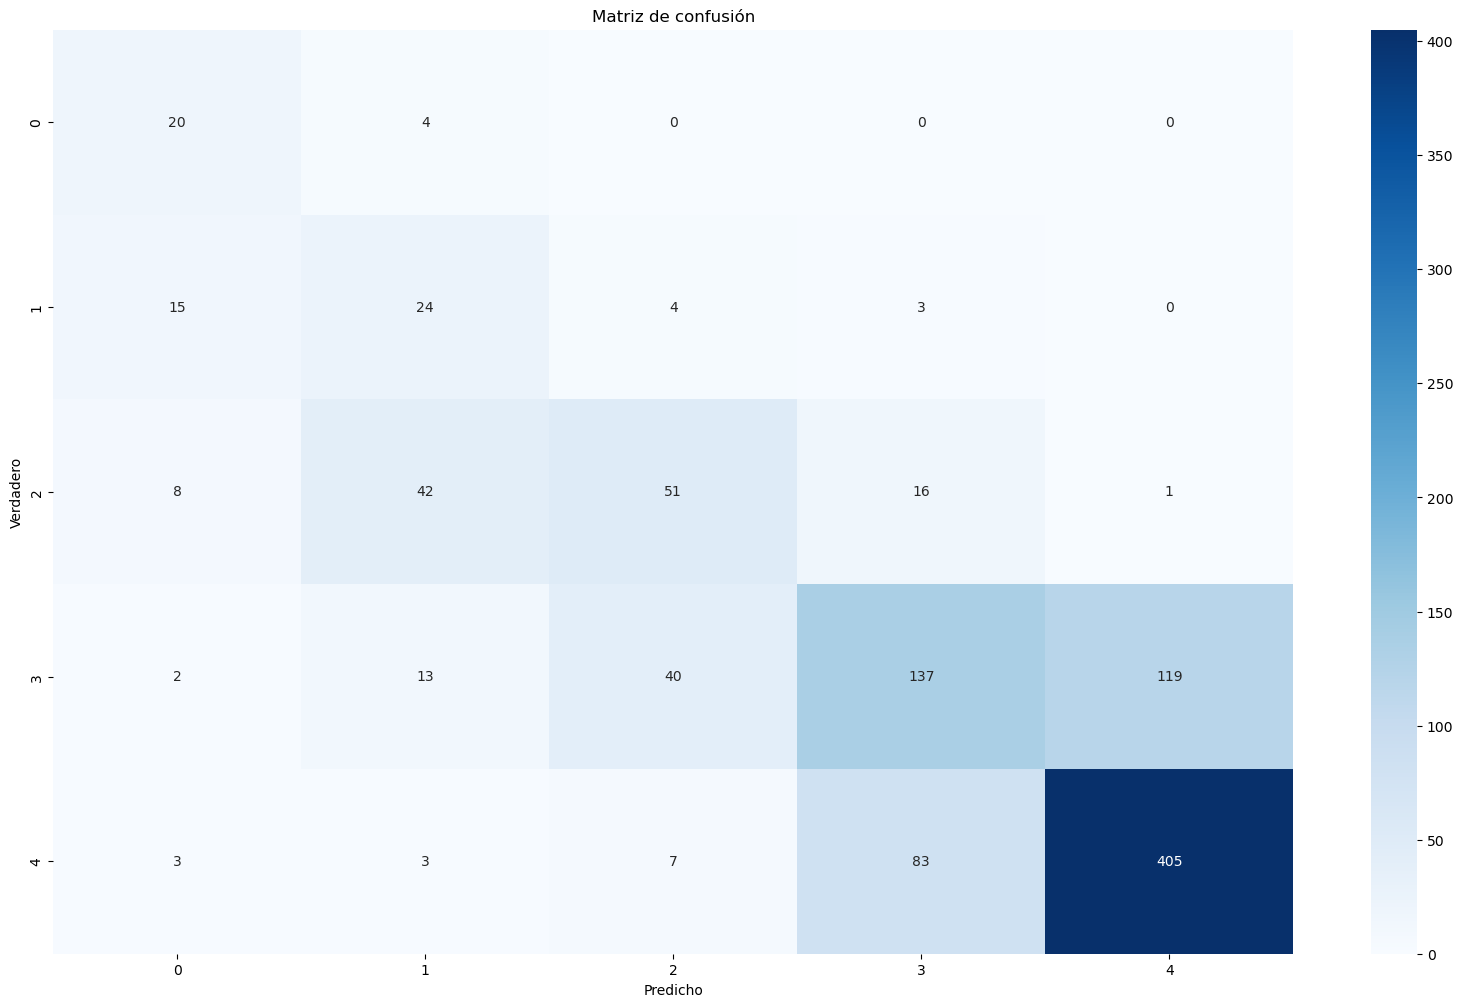

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_first_1000['score'].astype(int), df_first_1000['stars_predicted'].str.split(" ").str[0].astype(int))

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()